In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

def visualize_bounding_boxes(
    image, result, block_types=["WORD"], min_confidence=0.0, vis="bb", color_conditions=None
):
    """
    Visualizes bounding boxes from Textract result on the image for the specified block type.

    Args:
        image_path (str): Path to the image file.
        textract_result (dict): Textract result dictionary.
        block_types (list): List of types of block to visualize. (PAGE, LINE, WORD)
        min_confidence (float): Minimum confidence of block to show, in the range (0-100)
        vis (str) : visualization, either bounding box - bb or polygon - poly

        PAGE: The PAGE block type represents a single page within the document.
        It encapsulates the entire content of a page, including text, tables, images, and other elements.

        LINE: The LINE block type represents a line of text. It typically corresponds to a horizontal sequence of words or characters.
        The LINE blocks are usually used to reconstruct the flow and order of text within a document.

        WORD: The WORD block type represents an individual word or group of contiguous characters recognized by Textract.
        It captures the smallest units of text within a document and provides the text content as well as the bounding box coordinates for positioning.
    """

    image_height = image.height
    image_width = image.width
    print(image_height, image_width)
    # Plot the image
    # Increase the figure size to see the image clearly
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.axis("off")

    default_color = "r"  # default bounding box color

    # Extract bounding boxes
    blocks = result
    for block in blocks:
        box_color = default_color
        if color_conditions:
            for attribute, color in color_conditions.items():
                if block.get(attribute, False):
                    box_color = color
                    break  # Take the first valid condition, or you can continue checking all

        if vis == "bb":
            bounding_box = block

            left = int(bounding_box["x"] * image_width)
            top = int(bounding_box["y"] * image_height)
            width = int(bounding_box["width"] * image_width)
            height = int(bounding_box["height"] * image_height)

            # Draw bounding box on the image
            rect = plt.Rectangle(
                (left, top),
                width,
                height,
                linewidth=1,
                edgecolor=box_color,
                facecolor="none",
            )

        plt.gca().add_patch(rect)

    # Show the image with bounding boxes
    plt.show()



631 1000


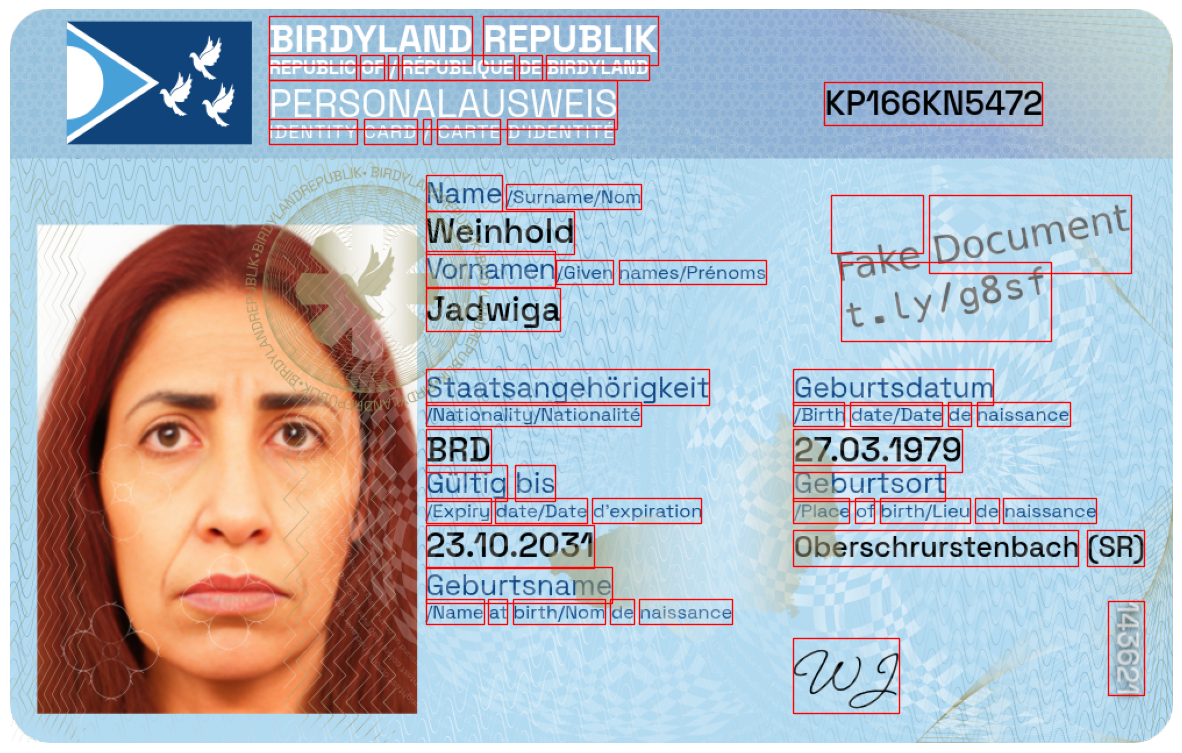

631 1000


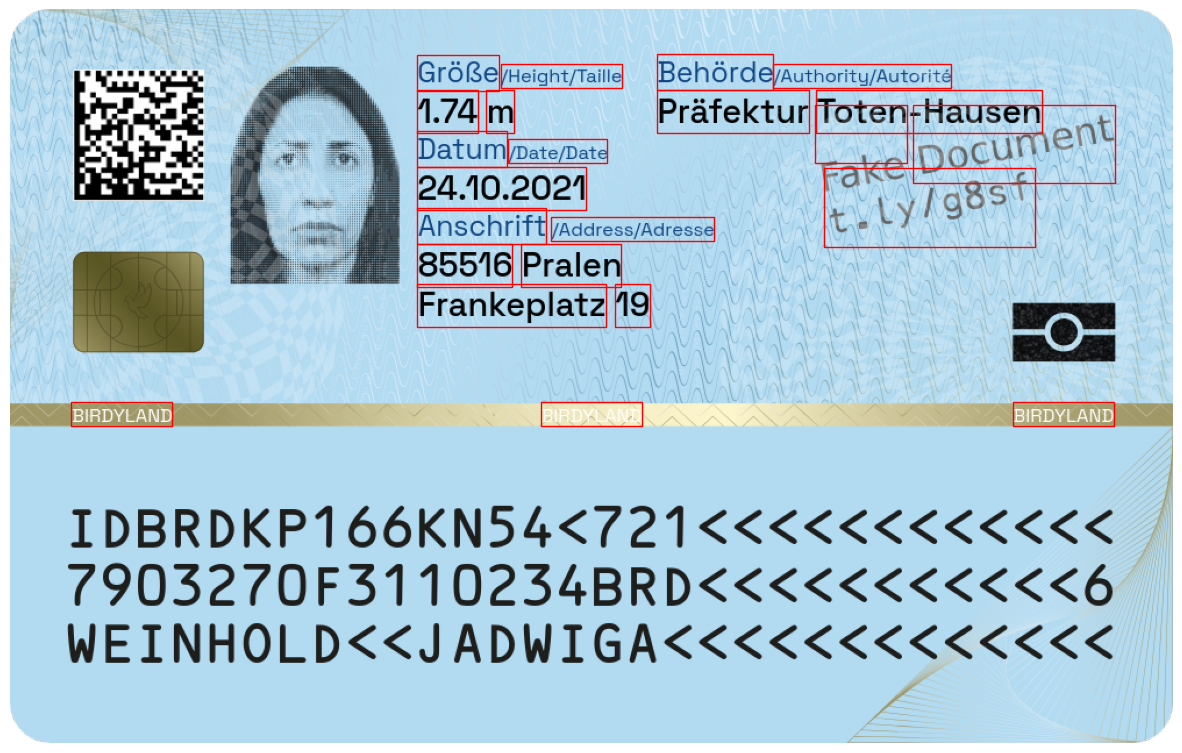

In [4]:
ocr_dataset_path = "test_ocr/test.json"
with open(ocr_dataset_path, "r") as f:
    ocr_dataset = json.load(f)

document_images_path = Path("test")

# Loop through the dataset["documents"]
for document in ocr_dataset["documents"]:
    # Load the image
    image_path = document_images_path / document["filename"]
    image = Image.open(image_path)

    
    ocr_data = document["ocr_data"]
    page_dict = [el for el in ocr_data if el.get("blockType") == "PAGE"][0]
    pageX = page_dict["x"]
    pageY = page_dict["y"]
    pageW = page_dict["width"]
    pageH = page_dict["height"]

    words = [el for el in ocr_data if el.get("blockType") != "PAGE"]

    for el in words:
        el["x"] = (el["x"] - pageX)/pageW
        el["y"] = (el["y"] - pageY)/pageH
        el["width"] = el["width"]/pageW
        el["height"] = el["height"]/pageH

    # Visualize the bounding boxes
    visualize_bounding_boxes(image, 
                             words, 
                             block_types=["WORD"], 
                             min_confidence=0.0, 
                             vis="bb")